In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import cmcrameri.cm as cm

from tqdm import tqdm
from utils import ELFData, ELFModel

## Load and filter data

In [2]:
# Load data
unlabeled = ELFData()
unlabeled.load_processed(dirname='data/unlabeled', structure=False)
print('Number of examples:', len(unlabeled.data))
unlabeled.data.head()

Parse profiles: 100%|██████████| 320585/320585 [00:19<00:00, 16863.23it/s]      


Number of examples: 320585


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,edge_dst,l,r_diff,g_diff,specie_src,specie_dst,mixed,id
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,4,3.812422,1.2,16,K,Cl,False,0
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,5,3.812422,1.2,16,K,Cl,False,0
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,6,3.812422,1.2,16,K,Cl,False,0
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,7,3.812422,1.2,16,K,Cl,False,0
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,8,3.812422,1.2,16,K,Cl,False,0


In [3]:
# Sort and filter data
unlabeled.data = unlabeled.data[~unlabeled.data['mixed']].reset_index(drop=True)
unlabeled.get_pdf_cdf()
unlabeled.sort_by_cdf()
print('Number of examples:', len(unlabeled.data))
unlabeled.data.head()

Number of examples: 279511


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,...,specie_src,specie_dst,mixed,id,A,pdf,cdf,elf_srt,pdf_srt,cdf_srt
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.2036299837170363, 0.284...","[0.014509947675761763, 0.017329271852047804, 0...","[0.014509947675761763, 0.03183921952780957, 0...."
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.20362998371703642, 0.28...","[0.014509947675761763, 0.017329271852047815, 0...","[0.014509947675761763, 0.031839219527809576, 0..."
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,K,Cl,False,0,12.044611,"[0.00012725870353490256, 0.0005892596846916265...","[0.00012725870353490256, 0.000716518388226529,...","[0.22271259596505436, 0.18323072767531332, 0.1...","[0.018490642709179408, 0.015212673105021801, 0...","[0.018490642709179408, 0.03370331581420121, 0...."
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,K,Cl,False,0,11.750637,"[0.00013044242258193029, 0.0002012628742761318...","[0.00013044242258193029, 0.0003317052968580622...","[0.1705011286207772, 0.2036299837170363, 0.284...","[0.014509947675761763, 0.017329271852047804, 0...","[0.014509947675761763, 0.03183921952780957, 0...."
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,K,Cl,False,0,12.044611,"[0.00012725870353490256, 0.0005892596846916265...","[0.00012725870353490256, 0.000716518388226529,...","[0.2227125959650543, 0.18323072767531332, 0.19...","[0.0184906427091794, 0.015212673105021801, 0.0...","[0.0184906427091794, 0.033703315814201204, 0.0..."


### Calculate columns

In [4]:
unlabeled.data['pdf-l_srt'] = unlabeled.data[['pdf_srt', 'l']].apply(
    lambda x: x.pdf_srt/(x.l/len(x.pdf_srt)), axis=1)

unlabeled.data['cdf-A_srt'] = unlabeled.data[['cdf_srt', 'A']].apply(lambda x: x.cdf_srt*x.A, axis=1)

## Predict data classes

In [5]:
n_classes = 4
n_components = 10
columns = ['elf_srt', 'pdf_srt', 'pdf-l_srt', 'cdf_srt', 'cdf-A_srt']
features = ['l', 'A']

### Load models

In [6]:
savedir = 'models/'
models = []
for column in columns:
    path = '_'.join([i + str(j) for (i,j) in zip(['c', 'z'], [n_classes, n_components])] + [column] + features)
    models.append(ELFModel(n_classes))
    models[-1].load_model(savedir + path)

### Predict

In [7]:
for i in tqdm(range(len(columns)), bar_format=unlabeled.bar_format):
    models[i].prepare_inputs(unlabeled.data)
    unlabeled.data = models[i].clf_ensemble_predict(unlabeled.data)

100%|██████████| 5/5 [08:17<00:00, 99.58s/it]                                   


In [8]:
unlabeled.data.head()

,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,...,cdf_srt_pred_std,cdf_srt_class,cdf_srt_class_mean,cdf_srt_class_std,z_cdf-A_srt,cdf-A_srt_pred_mean,cdf-A_srt_pred_std,cdf-A_srt_class,cdf-A_srt_class_mean,cdf-A_srt_class_std
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,"[0.0352404584831413, 0.003752416475350393, 0.0...",3,0.632646,0.058509,"[-11.679129332372147, 5.348374937186667, 0.086...","[0.04341157370883215, 0.00013333333333333334, ...","[0.023701162498353173, 0.0013266499161421607, ...",3,0.569906,0.082963
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,"[0.0352404584831413, 0.003752416475350393, 0.0...",3,0.632646,0.058509,"[-11.679129332372147, 5.348374937186667, 0.086...","[0.04341157370883215, 0.00013333333333333334, ...","[0.023701162498353173, 0.0013266499161421607, ...",3,0.569906,0.082963
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,"[0.03773243552764649, 0.007470237241510105, 0....",3,0.588196,0.068003,"[-11.538736624581158, 4.111602767696473, -1.25...","[0.10533522972731874, 0.002, 0.506694692753113...","[0.03959578657673422, 0.005456901847914973, 0....",2,0.506695,0.061309
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,...,"[0.0352404584831413, 0.003752416475350393, 0.0...",3,0.632646,0.058509,"[-11.679129332372147, 5.348374937186667, 0.086...","[0.04341157370883215, 0.00013333333333333334, ...","[0.023701162498353173, 0.0013266499161421607, ...",3,0.569906,0.082963
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,...,"[0.03773243552764649, 0.007470237241510105, 0....",3,0.588196,0.068003,"[-11.538736624581158, 4.111602767696473, -1.25...","[0.10533522972731874, 0.002, 0.506694692753113...","[0.03959578657673422, 0.005456901847914973, 0....",2,0.506695,0.061309


In [9]:
n_bins = 10
_, bins = np.histogram(unlabeled.data['l'], bins=n_bins)
unlabeled.data['l_bin'] = np.digitize(unlabeled.data['l'], bins[:-1], right=False).tolist()

_, bins = np.histogram(unlabeled.data['A'], bins=n_bins)
unlabeled.data['A_bin'] = np.digitize(unlabeled.data['A'], bins[:-1], right=False).tolist()

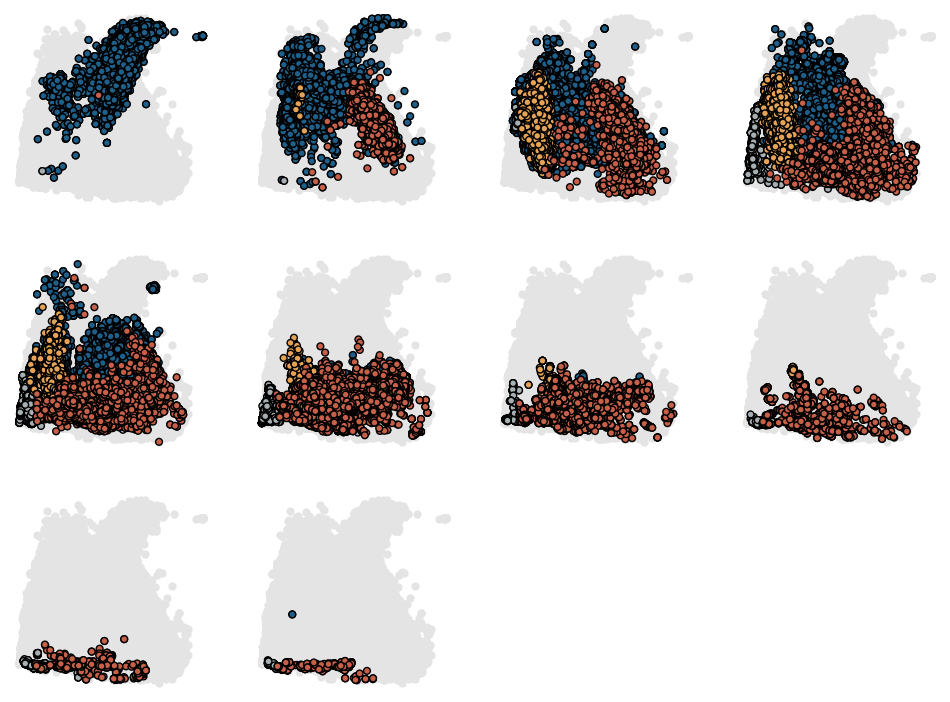

In [10]:
i = 0
x = [np.stack(unlabeled.data.loc[unlabeled.data['l_bin']==k, 'z_' + columns[i]].values) for k in range(1,n_bins+1)]
y = [unlabeled.data.loc[unlabeled.data['l_bin']==k, columns[i] + '_class'].values for k in range(1,n_bins+1)]
fig = models[i].plot_projection_slices(x=x, y=y, axes=[0,1], cmap=models[i].dmap, order=True)

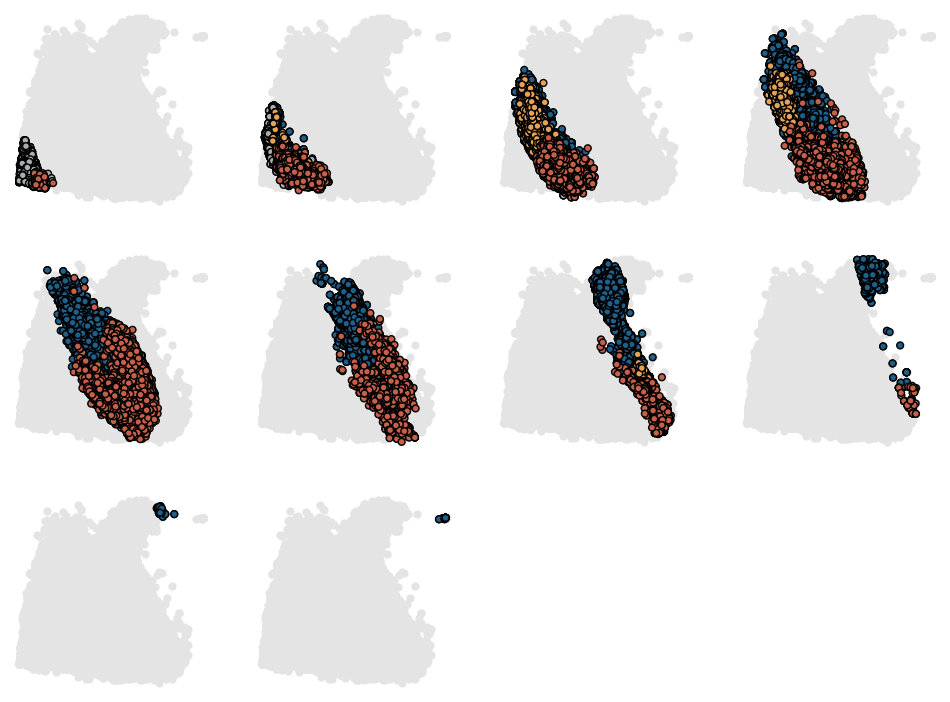

In [11]:
x = [np.stack(unlabeled.data.loc[unlabeled.data['A_bin']==k, 'z_' + columns[i]].values) for k in range(1,n_bins+1)]
y = [unlabeled.data.loc[unlabeled.data['A_bin']==k, columns[i] + '_class'].values for k in range(1,n_bins+1)]
fig = models[i].plot_projection_slices(x=x, y=y, axes=[0,1], cmap=models[i].dmap, order=True)